# ReadCSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing required libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup
#from google.colab import drive
from tqdm import tqdm

from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import scale


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/train.csv')
data_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/test.csv')
data_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
data_train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
data_test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [ ]:
data_train['text'].iloc[1]

'Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mor

#### We are going to use text and author as the way to check fraud or not

In [ ]:
# filling NA with the blank spaces

data_train=data_train.fillna('')
data_test=data_test.fillna('')

In [ ]:
data_train['text_total'] = data_train['author'] + ' ' + data_train['text'] 
data_test['text_total']= data_test['author'] + ' ' + data_test['text']

In [ ]:
data_test.head()

,id,title,author,text,text_total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","David Streitfeld PALO ALTO, Calif. — After ..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists n...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,Common Dreams Videos #NoDAPL: Native American ...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Daniel Victor If at first you don’t succeed, t..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Truth Broadcast Network 42 mins ago 1 Views 0 ...


In [ ]:
data_test.shape

(5200, 5)

In [ ]:
data_train.head()

,id,title,author,text,label,text_total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Daniel J. Flynn Ever get the feeling your life...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss Videos 15 Civilians Killed In ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Print \nAn Iranian woman has be...


In [ ]:
#X = df.drop('label',axis=1)
y=data_train['label']
#print(X.shape)
print(y.shape)

(20800,)


In [ ]:
data_test['text_total'].loc[1]

' Russian warships ready to strike terrorists near Aleppo 08.11.2016 | Source: Source: Mil.ru Attack aircraft of the Russian aircraft carrier Admiral Kuznetsov get ready to strike terrorists\' positions in the vicinity of Aleppo, sources at the Russian Defense Ministry said, RBC reports. "Insurgents\' attempts to break into Aleppo from outside are meaningless," the source said. The main task of the aircraft carrier aviation group is to strike missile and air blows on the terrorists , whose goal is to enter Aleppo. "After the attacks on terrorists\' positions, one will have to forget about the support for insurgents from the outside," the source said. The Russian group in the Mediterranean Sea consists of the Admiral Kuznetsov aircraft carrier , the heavy nuclear missile cruiser Pyotr Velikiy (Peter the Great) and large anti-submarine ships Severomorsk and Vice-Admiral Kulakov. Russia has increased intelligence activities in Syria to establish the areas, where terrorists are concentrate

# Data Preprocessing

### Removing of special character, stopwords removal, spaces, tab removal, making it to lower cases.

In [ ]:
## Function to preprocess the data 

def pre_processing(sen):

  #Remove URL
  sen = re.sub(r'http\S+', '', sen)
  sen = ''.join(sen)

  ## this is to remove the html tags in the sentences 
  text = BeautifulSoup(sen).get_text()
  text = ''.join(text)

  ## Remove email addresses 
  text = ' '.join([item for item in text.split() if '@' not in item])
    
  #Remove the punctuations 
  text_updated = [x for x in text if x not in '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~—-’‘''']
  text_updated = ''.join(text_updated)

  ##Remove multiple spaces from string
  text_updated = re.sub(' +', ' ', text_updated)
  text_updated = ''.join(text_updated)
    
  #Consider only characters
  text_updated = re.sub('^a-zA-Z',' ',text_updated)
  text_updated = ''.join(text_updated)
    
  ##replace new line with space 
  text_updated = re.sub('\n',' ',text_updated)
  text_updated = ''.join(text_updated)
    
  ##convert it into lower case 
  text_updated = text_updated.lower()
    
    
  return text_updated

In [ ]:
data_train['text_total'] = data_train['text_total'].apply(pre_processing)
data_test['text_total'] = data_test['text_total'].apply(pre_processing)

In [ ]:
## performing others steps on training data

## removing the stop words
data_train['text_total'] = [remove_stopwords(x) for x in data_train['text_total']]
data_test['text_total'] = [remove_stopwords(x) for x in data_test['text_total']]

##Tokenizing the sentence
data_train['text_total'] = [simple_preprocess(x,deacc=True) for x in data_train['text_total']]
data_test['text_total'] = [simple_preprocess(x,deacc=True) for x in data_test['text_total']]

  
##Then Lemmatizing the sentence
# lemmatizer = WordNetLemmatizer()
# data_train['text_total'] = [' '.join([lemmatizer.lemmatize(word) for word in tokens.split()]) for tokens in data_train['text_total']]
# data_test['text_total'] = [' '.join([lemmatizer.lemmatize(word) for word in tokens.split()]) for tokens in data_test['text_total']]

#For Tokenization use below
lemmatizer = WordNetLemmatizer()
data_train['text_total'] = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in data_train['text_total']]
data_test['text_total'] = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in data_test['text_total']]

In [ ]:
data_train

,id,title,author,text,label,text_total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[darrell, lucus, house, dem, aide, didnt, come..."
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"[daniel, flynn, feeling, life, circle, roundab..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"[truth, fired, october, tension, intelligence,..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,"[jessica, purkiss, video, civilian, killed, si..."
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,"[howard, portnoy, print, iranian, woman, sente..."
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,"[jerome, hudson, rapper, unloaded, black, cele..."
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"[benjamin, hoffman, green, bay, packer, lost, ..."
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,"[michael, la, merced, rachel, abrams, macys, t..."
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"[alex, ansary, nato, russia, hold, parallel, e..."


In [ ]:
#data_train["preprop_text"] = preprocess_text(data_train["text_total"])


In [ ]:
#data_test["preprop_text"] = preprocess_text(data_test["text_total"])

In [ ]:
#def decontracted(phrase):
#    phrase = re.sub(r"won't", "will not", phrase)
#    phrase = re.sub(r"can \' t", "can not", phrase)
#    phrase = re.sub(r"n \' t", " not", phrase)
#    phrase = re.sub(r" \' re", " are", phrase)
#    phrase = re.sub(r" \' s", " is", phrase)
#    phrase = re.sub(r" \' d", " would", phrase)
#    phrase = re.sub(r" \' ll", " will", phrase)
#    phrase = re.sub(r" \' t", " not", phrase)
#    phrase = re.sub(r" \' ve", " have", phrase)
#    phrase = re.sub(r" \' m", " am", phrase)
       

In [ ]:
#data_train['preprop_text']=data_train['preprop_text'].apply(lambda z: decontracted(z))


In [ ]:
#data_test['preprop_text']=data_test['preprop_text'].apply(lambda z: decontracted(z))

In [ ]:
#len(data_train)

In [ ]:
#data_test['preprop_text'][2]

# Applying  Lemmatization 

Applied stemming as its faster compared to Lemmatization eventhough Lemmatization gives good result but its costly for large datasets

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer() # creating an object of potter stemmer

applying to the dataframe
data_processed_test["preprop_text"] = data_processed_test["preprop_text"].apply(lambda x : " ".join(ps.stem(val) for val in x.split()))

In [ ]:
ps = PorterStemmer() ## creating an object of potter stemmer

# applying to the dataframe
data_processed["preprop_text"] = data_processed["preprop_text"].apply(lambda x : " ".join(ps.stem(val) for val in x.split()))

In [ ]:
#l[0]

In [ ]:
data_processed_test["preprop_text"][1]

In [ ]:
for d in data_processed["preprop_text"]:
   print(d)

In [ ]:
l=[]
for i in data_processed["preprop_text"]:
   l.append(i)
l

In [ ]:
#m=[]
#for j in data_processed_test["preprop_text"]:
#    m.append(j)
#m

In [ ]:
#len(m)

In [ ]:
def convert_list_to_string(sen):
  text = [str(x) for x in sen]
  text = ' '.join(text)
  return text

# Supervised Learning for WordEmbedding

1) I am going to use RNN as it does not label the words while wordembedding

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding


In [ ]:
from tensorflow.keras.layers import LSTM,Dense,Dropout

In [ ]:
vocab_size = 5000
encoded_txt_train = [one_hot(d, vocab_size) for d in data_train["text_total"]]
print(encoded_txt_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
vocab_size = 5000
encoded_txt_test = [one_hot(d, vocab_size) for d in data_test["text_total"]]
print(encoded_txt_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
len(data_test)

5200

In [ ]:
padding_train = pad_sequences(encoded_txt_train,padding='pre',maxlen=25)
padding_test = pad_sequences(encoded_txt_test,padding='pre',maxlen=25)

In [ ]:
#y_train=data_train['label']
y_train=y

In [ ]:
#y_test=data_test['label']

In [ ]:
y_train.size

20800

In [ ]:
len(padding_train)

20800

In [ ]:
len(padding_test)

5200

# RNN model

I am using LSTM here can also use GRU as its useful to solve vanishing gradient descent and also as we know our RNN model have short term memory thses LSTM layers and GRU helps in rembering some important words that may be forgotten by our model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,40,input_length=25))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='LeakyReLU'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
X_train = np.array(padding_train)
y_train_new = np.array(y_train)
X_test = np.array(padding_test)
X_train.shape,y_train_new.shape,X_test.shape

((20800, 25), (20800,), (5200, 25))

In [ ]:
y_train_new

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
model.fit(X_train,y_train_new,epochs=20,batch_size=64)


Epoch 1/20
325/325 [==============================] - 9s 6ms/step - loss: 0.3130 - accuracy: 0.8514
Epoch 2/20
325/325 [==============================] - 2s 5ms/step - loss: 0.1808 - accuracy: 0.9258
Epoch 3/20
325/325 [==============================] - 2s 5ms/step - loss: 0.1337 - accuracy: 0.9485
Epoch 4/20
325/325 [==============================] - 2s 5ms/step - loss: 0.1004 - accuracy: 0.9628
Epoch 5/20
325/325 [==============================] - 2s 5ms/step - loss: 0.0776 - accuracy: 0.9709
Epoch 6/20
325/325 [==============================] - 2s 5ms/step - loss: 0.0607 - accuracy: 0.9775
Epoch 7/20
325/325 [==============================] - 2s 5ms/step - loss: 0.0465 - accuracy: 0.9825
Epoch 8/20
325/325 [==============================] - 2s 5ms/step - loss: 0.0335 - accuracy: 0.9869
Epoch 9/20
325/325 [==============================] - 2s 5ms/step - loss: 0.0328 - accuracy: 0.9881
Epoch 10/20
325/325 [==============================] - 2s 5ms/step - loss: 0.0276 - accuracy: 0.9899

In [ ]:
#y_test_some=model.predict('Russian warships ready to strike terrorists near Aleppo')

In [ ]:
 #= model.predict_classes(X_test)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [ ]:
#classes_x

In [ ]:
nlp_proj = pd.DataFrame()
nlp_proj['id']=data_test['id']
nlp_proj['label'] = y_pred

In [ ]:
nlp_proj

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,1
5196,25996,0
5197,25997,0
5198,25998,1


In [ ]:
#final_sub['label'].value_counts()

In [ ]:
#final_sub

In [ ]:
nlp_proj.to_csv('NLP_Project_RNN.csv')

# TF-IDF 
Another Vectorization Approach  (better than bagofwords). Handles frequency of frequent occuring element and helps in the words that we want the machine to give importance. Highlighting the unique word

In [ ]:
sentences = data_train['text_total'].apply(convert_list_to_string)
test_sentences =data_test['text_total'].apply(convert_list_to_string)

In [ ]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# splitting of data


xtrain1, xval, ytrain1, yval = train_test_split(sentences, y, stratify = y, test_size=0.20, random_state=42)
xtrain1.shape, xval.shape, ytrain1.shape, yval.shape 

((16640,), (4160,), (16640,), (4160,))

In [ ]:
xtrain1.head()

18697    yamiche alcindor washington attorney general e...
19320    erik eckholm gov mary fallin oklahoma vetoed f...
13879    communal harmony anandi sharan november monday...
15282    nadia prupis terrifying att spying american pr...
17746    news effort prove credibility undercover donor...
Name: text_total, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## initializing count vectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), 
                             stop_words="english", min_df = 10, max_df = 0.95, max_features = 5000)
## fitting data
tfidf_vect.fit(xtrain1)

## transforming data
xtrain_tfidf =  tfidf_vect.transform(xtrain1)
xtest_tfidf =  tfidf_vect.transform(xval)

print(f"xtrain shape : {xtrain_tfidf.shape}, xtest shape : {xtest_tfidf.shape}")

xtrain shape : (16640, 5000), xtest shape : (4160, 5000)


In [ ]:
#Submission kaggle score
xtest_kaggle =  tfidf_vect.transform(test_sentences)
xtest_kaggle.shape

(5200, 5000)

In [ ]:
#xtest_kaggle.idf

#### Logistic Regression with  TFIDF



In [ ]:
lr = LogisticRegression()

lr.fit(xtrain_tfidf, ytrain1)

LogisticRegression()

In [ ]:
## Testing the model 

##Train data 
y_pred_train = lr.predict(xtrain_tfidf)
print("accuracy:" ,accuracy_score(ytrain1,y_pred_train))
print("\n\n Confusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\n Classification Report\n", classification_report(ytrain1,y_pred_train))

accuracy: 0.9654447115384616


 Confusion matrix
 [[7992  318]
 [ 257 8073]]


 Classification Report
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      8310
           1       0.96      0.97      0.97      8330

    accuracy                           0.97     16640
   macro avg       0.97      0.97      0.97     16640
weighted avg       0.97      0.97      0.97     16640



In [ ]:
## Test data

y_pred_test = lr.predict(xtest_tfidf)
print("accuracy:" , accuracy_score(yval,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(yval,y_pred_test))
print("\n\nClassification Report\n", classification_report(yval,y_pred_test))

accuracy: 0.9427884615384615


Confusion matrix
 [[1940  137]
 [ 101 1982]]


Classification Report
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      2077
           1       0.94      0.95      0.94      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



#### SVM with TFIDF

In [ ]:
svc = SVC(kernel='linear')

svc.fit(xtrain_tfidf, ytrain1)

SVC(kernel='linear')

In [ ]:
## Testing the model 

##Train data 
y_pred_train = svc.predict(xtrain_tfidf)
print("accuracy Score:" , accuracy_score(ytrain1,y_pred_train))
print("\n\nConfusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\nClassification Report\n", classification_report(ytrain1,y_pred_train))

accuracy Score: 0.9810096153846154


Confusion matrix
 [[8139  171]
 [ 145 8185]]


Classification Report
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      8310
           1       0.98      0.98      0.98      8330

    accuracy                           0.98     16640
   macro avg       0.98      0.98      0.98     16640
weighted avg       0.98      0.98      0.98     16640



In [ ]:
## Test data
y_pred_test = svc.predict(xtest_tfidf)
print("accuracy:", accuracy_score(yval,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(yval,y_pred_test))
print("\n\nClassification Report", classification_report(yval,y_pred_test))

accuracy: 0.9473557692307693


Confusion matrix
 [[1958  119]
 [ 100 1983]]


Classification Report               precision    recall  f1-score   support

           0       0.95      0.94      0.95      2077
           1       0.94      0.95      0.95      2083

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



#### RANDOM FOREST with TFDIF

In [ ]:
rf = RandomForestClassifier()

rf.fit(xtrain_tfidf, ytrain1)

RandomForestClassifier()

In [ ]:
## Testing the model 

##Train data 
y_pred_train = rf.predict(xtrain_tfidf)
print("accuracy Score:" , accuracy_score(ytrain1,y_pred_train))
print("\n\nConfusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\nClassification Report", classification_report(ytrain1,y_pred_train))

accuracy Score: 1.0


Confusion matrix
 [[8310    0]
 [   0 8330]]


Classification Report               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8310
           1       1.00      1.00      1.00      8330

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640



In [ ]:

## Test data
y_pred_test = rf.predict(xtest_tfidf)
print("accuracy:", accuracy_score(yval,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(yval,y_pred_test))
print("\n\nClassification Report", classification_report(yval,y_pred_test))

accuracy: 0.9444711538461539


Confusion matrix
 [[1979   98]
 [ 133 1950]]


Classification Report               precision    recall  f1-score   support

           0       0.94      0.95      0.94      2077
           1       0.95      0.94      0.94      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



#### XGBOOST with TFIDF

In [ ]:
xg = xgb.XGBClassifier()
xg.fit(xtrain_tfidf, ytrain1)

XGBClassifier()

In [ ]:
## Testing the model 

##Train data 
y_pred_train = xg.predict(xtrain_tfidf)
print("accuracy Score:" , accuracy_score(ytrain1,y_pred_train))
print("\n\nConfusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\nClassification Report", classification_report(ytrain1,y_pred_train))

accuracy Score: 0.9432091346153846


Confusion matrix
 [[7716  594]
 [ 351 7979]]


Classification Report               precision    recall  f1-score   support

           0       0.96      0.93      0.94      8310
           1       0.93      0.96      0.94      8330

    accuracy                           0.94     16640
   macro avg       0.94      0.94      0.94     16640
weighted avg       0.94      0.94      0.94     16640



In [ ]:
## Test data
y_pred_test = rf.predict(xtest_tfidf)
print("accuracy:", accuracy_score(yval,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(yval,y_pred_test))
print("\n\nClassification Report", classification_report(yval,y_pred_test))

accuracy: 0.9444711538461539


Confusion matrix
 [[1979   98]
 [ 133 1950]]


Classification Report               precision    recall  f1-score   support

           0       0.94      0.95      0.94      2077
           1       0.95      0.94      0.94      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



#### gradient boost classifier

In [ ]:
#Using gradient boost classifier to check results

clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, random_state = 100)
clf.fit(xtrain_tfidf, ytrain1)

GradientBoostingClassifier(random_state=100)

In [ ]:
# training confusion matrix

y_train_pred1 = clf.predict(xtrain_tfidf)
confusion_matrix(ytrain1,y_train_pred1)

array([[7723,  587],
       [ 366, 7964]])

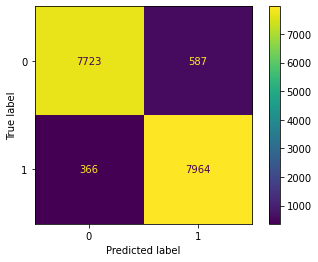

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytrain1,y_train_pred1)).plot();

In [ ]:
print(classification_report(ytrain1,y_train_pred1))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      8310
           1       0.93      0.96      0.94      8330

    accuracy                           0.94     16640
   macro avg       0.94      0.94      0.94     16640
weighted avg       0.94      0.94      0.94     16640



In [ ]:
# testing confusion matrix
y_test_pred1 = clf.predict(xtest_tfidf)
confusion_matrix(yval,y_test_pred1)

array([[1883,  194],
       [ 117, 1966]])

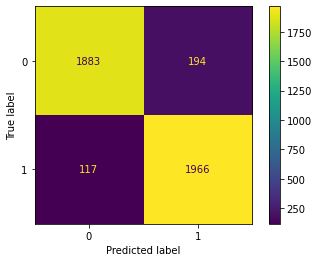

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(yval,y_test_pred1)).plot();

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(yval,y_test_pred1))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2077
           1       0.91      0.94      0.93      2083

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



In [ ]:
y_test_predkaggle = clf.predict(xtest_kaggle)

In [ ]:
#y_test_predkaggle

In [ ]:
nlp_proj = pd.DataFrame()
nlp_proj['id']=data_test['id']
nlp_proj['label'] = y_test_predkaggle

In [ ]:
nlp_proj.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [ ]:
nlp_proj.to_csv('NLP_Project_GB.csv')

In [ ]:
from gensim.models.word2vec import Word2Vec

In [ ]:
# Using word to vec
alg = Word2Vec(size= 500, min_count = 1)
alg.build_vocab(xtrain1)
alg.train(data_train['text_total'], total_examples = len(xtrain1), epochs = alg.epochs)

(17865, 40170300)

In [ ]:
# word2vec for sentence
def convert_word_to_vector(sms, size):
    vec = np.zeros(500).reshape((1, 500))
    count = 0
    for word in sms:
        try:
            vec = vec+ alg.wv[word].reshape((1, size))
            count = count+1.
        except KeyError:
            continue
    if count != 0:
        vec = vec/count
    return vec

In [ ]:
# converting training and testing to vectors
data_processed_vecs = scale(np.concatenate([convert_word_to_vector(z, 500) for z in xtrain1]))
data_processed_test_vecs = scale(np.concatenate([convert_word_to_vector(z, 500) for z in xval]))

In [ ]:
# converting validation vectors for kaggle submission
data_processed_kaggle_sub_vecs = scale(np.concatenate([convert_word_to_vector(z, 500) for z in data_test["text_total"]]))

**MODEL BUILDING**



In [ ]:
## Importing packages 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb

### Logistic Regression with Word2Vec

In [ ]:
lr = LogisticRegression()

lr.fit(data_processed_vecs, ytrain1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
## Testing the model 

##Train data 
y_pred_train = lr.predict(data_processed_vecs)
print("accuracy:" ,accuracy_score(ytrain1,y_pred_train))
print("\n\n Confusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\n Classification Report\n", classification_report(ytrain1,y_pred_train))

accuracy: 0.6574519230769231


 Confusion matrix
 [[5516 2794]
 [2906 5424]]


 Classification Report
               precision    recall  f1-score   support

           0       0.65      0.66      0.66      8310
           1       0.66      0.65      0.66      8330

    accuracy                           0.66     16640
   macro avg       0.66      0.66      0.66     16640
weighted avg       0.66      0.66      0.66     16640



In [ ]:
## Test data

y_pred_test = lr.predict(data_processed_test_vecs)
print("accuracy:" , accuracy_score(yval,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(yval,y_pred_test))
print("\n\nClassification Report\n", classification_report(yval,y_pred_test))

accuracy: 0.6572115384615385


Confusion matrix
 [[1402  675]
 [ 751 1332]]


Classification Report
               precision    recall  f1-score   support

           0       0.65      0.68      0.66      2077
           1       0.66      0.64      0.65      2083

    accuracy                           0.66      4160
   macro avg       0.66      0.66      0.66      4160
weighted avg       0.66      0.66      0.66      4160



### SVM with Word2Vec

In [ ]:
svc = SVC(kernel='linear')

svc.fit(data_processed_vecs, ytrain1)

SVC(kernel='linear')

In [ ]:
## Testing the model 

##Train data 
y_pred_train = svc.predict(data_processed_vecs)
print("accuracy Score:" , accuracy_score(ytrain1,y_pred_train))
print("\n\nConfusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\nClassification Report", classification_report(ytrain1,y_pred_train))

accuracy Score: 0.6682692307692307


Confusion matrix
 [[5842 2468]
 [3052 5278]]


Classification Report               precision    recall  f1-score   support

           0       0.66      0.70      0.68      8310
           1       0.68      0.63      0.66      8330

    accuracy                           0.67     16640
   macro avg       0.67      0.67      0.67     16640
weighted avg       0.67      0.67      0.67     16640



In [ ]:
## Test data
y_pred_test = svc.predict(data_processed_test_vecs)
print("accuracy:", accuracy_score(yval,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(yval,y_pred_test))
print("\n\nClassification Report", classification_report(yval,y_pred_test))

accuracy: 0.6649038461538461


Confusion matrix
 [[1460  617]
 [ 777 1306]]


Classification Report               precision    recall  f1-score   support

           0       0.65      0.70      0.68      2077
           1       0.68      0.63      0.65      2083

    accuracy                           0.66      4160
   macro avg       0.67      0.66      0.66      4160
weighted avg       0.67      0.66      0.66      4160



### RANDOM FOREST with Word2Vec

In [ ]:
rf = RandomForestClassifier()

rf.fit(data_processed_vecs, ytrain1)

RandomForestClassifier()

In [ ]:
## Testing the model 

##Train data 
y_pred_train = rf.predict(data_processed_vecs)
print("accuracy Score:" , accuracy_score(ytrain1,y_pred_train))
print("\n\nConfusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\nClassification Report", classification_report(ytrain1,y_pred_train))

accuracy Score: 1.0


Confusion matrix
 [[8310    0]
 [   0 8330]]


Classification Report               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8310
           1       1.00      1.00      1.00      8330

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640



In [ ]:

## Test data
y_pred_test = rf.predict(data_processed_test_vecs)
print("accuracy:", accuracy_score(yval,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(yval,y_pred_test))
print("\n\nClassification Report", classification_report(yval,y_pred_test))

accuracy: 0.6723557692307692


Confusion matrix
 [[1465  612]
 [ 751 1332]]


Classification Report               precision    recall  f1-score   support

           0       0.66      0.71      0.68      2077
           1       0.69      0.64      0.66      2083

    accuracy                           0.67      4160
   macro avg       0.67      0.67      0.67      4160
weighted avg       0.67      0.67      0.67      4160



**XGBOOST with Word2Vec**

In [ ]:
xg = xgb.XGBClassifier()
xg.fit(data_processed_vecs, ytrain1)

XGBClassifier()

In [ ]:
## Testing the model 

##Train data 
y_pred_train = xg.predict(data_processed_vecs)
print("accuracy Score:" , accuracy_score(ytrain1,y_pred_train))
print("\n\nConfusion matrix\n", confusion_matrix(ytrain1,y_pred_train))
print("\n\nClassification Report", classification_report(ytrain1,y_pred_train))

accuracy Score: 0.6912259615384615


Confusion matrix
 [[6056 2254]
 [2884 5446]]


Classification Report               precision    recall  f1-score   support

           0       0.68      0.73      0.70      8310
           1       0.71      0.65      0.68      8330

    accuracy                           0.69     16640
   macro avg       0.69      0.69      0.69     16640
weighted avg       0.69      0.69      0.69     16640



In [ ]:
## Test data
y_pred_test = xg.predict(data_processed_vecs)
print("accuracy:", accuracy_score(ytrain1,y_pred_test))
print("\n\nConfusion matrix\n", confusion_matrix(ytrain1,y_pred_test))
print("\n\nClassification Report", classification_report(ytrain1,y_pred_test))

accuracy: 0.6912259615384615


Confusion matrix
 [[6056 2254]
 [2884 5446]]


Classification Report               precision    recall  f1-score   support

           0       0.68      0.73      0.70      8310
           1       0.71      0.65      0.68      8330

    accuracy                           0.69     16640
   macro avg       0.69      0.69      0.69     16640
weighted avg       0.69      0.69      0.69     16640



In [ ]:
from gensim.models import KeyedVectors
filename = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
## converting words to vector
def convert_word_to_vector(sms, size):
    vec = np.zeros(300).reshape((1, 300))
    count = 0
    for word in sms:
        try:
            vec += model.__getitem__(word).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
## splitting the dataset 

x_train, x_test, y_train, y_test = train_test_split(data_train['text_total'],y, test_size=0.2)

In [ ]:
# converting training and testing to vectors

x_train_vecs = scale(np.concatenate([convert_word_to_vector(z, 300) for z in x_train]))
x_test_vecs = scale(np.concatenate([convert_word_to_vector(z, 300) for z in x_test]))

#### Logistic Regression With Google News Vector

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_vecs, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
## predicting the data on train data

y_pred_train1 = lr.predict(x_train_vecs)
print('Accuracy', accuracy_score(y_pred_train1, y_train))
print('Confusion Matrix:\n', confusion_matrix(y_pred_train1, y_train))
print("\n\nClassification Report", classification_report(y_pred_train1, y_train))

Accuracy 0.8753004807692307
Confusion Matrix:
 [[7323 1082]
 [ 993 7242]]


Classification Report               precision    recall  f1-score   support

           0       0.88      0.87      0.88      8405
           1       0.87      0.88      0.87      8235

    accuracy                           0.88     16640
   macro avg       0.88      0.88      0.88     16640
weighted avg       0.88      0.88      0.88     16640



In [ ]:
## predicting the data on train data

y_pred_test1 = lr.predict(x_test_vecs)
print('\n\nAccuracy', accuracy_score(y_pred_test1, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_pred_test1, y_test))
print("\n\nClassification Report", classification_report(y_pred_test1, y_test))



Accuracy 0.8754807692307692
Confusion Matrix:
 [[1818  265]
 [ 253 1824]]


Classification Report               precision    recall  f1-score   support

           0       0.88      0.87      0.88      2083
           1       0.87      0.88      0.88      2077

    accuracy                           0.88      4160
   macro avg       0.88      0.88      0.88      4160
weighted avg       0.88      0.88      0.88      4160



#### SVM with Google News Vector

In [ ]:
svc = SVC(kernel='linear')

svc.fit(x_train_vecs, y_train)

SVC(kernel='linear')

In [ ]:
## Testing the model 

## predicting the data on train data

y_pred_train = svc.predict(x_train_vecs)
print("accuracy Score:" , accuracy_score(y_pred_train,y_train))
print("\n\nConfusion matrix\n", confusion_matrix(y_pred_train,y_train))
print("\n\nClassification Report", classification_report(y_pred_train,y_train))

accuracy Score: 0.8792668269230769


Confusion matrix
 [[7383 1076]
 [ 933 7248]]


Classification Report               precision    recall  f1-score   support

           0       0.89      0.87      0.88      8459
           1       0.87      0.89      0.88      8181

    accuracy                           0.88     16640
   macro avg       0.88      0.88      0.88     16640
weighted avg       0.88      0.88      0.88     16640



In [ ]:
## Test data
#predicting the data on test data

y_pred_test = svc.predict(x_test_vecs)
print("accuracy:", accuracy_score(y_pred_test,y_test))
print("\n\nConfusion matrix\n", confusion_matrix(y_pred_test,y_test))
print("\n\nClassification Report", classification_report(y_pred_test,y_test))

accuracy: 0.871875


Confusion matrix
 [[1817  279]
 [ 254 1810]]


Classification Report               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2096
           1       0.87      0.88      0.87      2064

    accuracy                           0.87      4160
   macro avg       0.87      0.87      0.87      4160
weighted avg       0.87      0.87      0.87      4160



#### Random Forest Classifier with Google News vector

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train_vecs, y_train)

RandomForestClassifier()

In [ ]:
## predicting the data on train data

y_pred_train2 = rf.predict(x_train_vecs)
print('Accuracy', accuracy_score(y_pred_train2, y_train))
print('Confusion Matrix:\n', confusion_matrix(y_pred_train2, y_train))
print("\n\nClassification Report", classification_report(y_pred_train2, y_train))

Accuracy 1.0
Confusion Matrix:
 [[8316    0]
 [   0 8324]]


Classification Report               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8316
           1       1.00      1.00      1.00      8324

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640



In [ ]:
## predicting the data on test data

y_pred_test2 = rf.predict(x_test_vecs)
print('\n\nAccuracy', accuracy_score(y_pred_test2, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_pred_test2, y_test))
print("\n\nClassification Report", classification_report(y_pred_test2, y_test))



Accuracy 0.8620192307692308
Confusion Matrix:
 [[1756  259]
 [ 315 1830]]


Classification Report               precision    recall  f1-score   support

           0       0.85      0.87      0.86      2015
           1       0.88      0.85      0.86      2145

    accuracy                           0.86      4160
   macro avg       0.86      0.86      0.86      4160
weighted avg       0.86      0.86      0.86      4160



#### XGBOOST with Google News Vector

In [ ]:
xg = xgb.XGBClassifier()

xg.fit(x_train_vecs, y_train)

XGBClassifier()

In [ ]:
## predicting the data on train data

y_pred_train3 = xg.predict(x_train_vecs)
print('Accuracy', accuracy_score(y_pred_train3, y_train))
print('Confusion Matrix:\n', confusion_matrix(y_pred_train3, y_train))
print("\n\nClassification Report", classification_report(y_pred_train3, y_train))

Accuracy 0.8768629807692307
Confusion Matrix:
 [[7417 1150]
 [ 899 7174]]


Classification Report               precision    recall  f1-score   support

           0       0.89      0.87      0.88      8567
           1       0.86      0.89      0.88      8073

    accuracy                           0.88     16640
   macro avg       0.88      0.88      0.88     16640
weighted avg       0.88      0.88      0.88     16640



In [ ]:
## Predicting the data on test data

y_pred_test3 = xg.predict(x_test_vecs)
print('\n\nAccuracy', accuracy_score(y_pred_test3, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_pred_test3, y_test))
print("\n\nClassification Report", classification_report(y_pred_test3, y_test))



Accuracy 0.8427884615384615
Confusion Matrix:
 [[1759  342]
 [ 312 1747]]


Classification Report               precision    recall  f1-score   support

           0       0.85      0.84      0.84      2101
           1       0.84      0.85      0.84      2059

    accuracy                           0.84      4160
   macro avg       0.84      0.84      0.84      4160
weighted avg       0.84      0.84      0.84      4160



# Stanford's GloVe pre-trained data

https://nlp.stanford.edu/projects/glove/

In [ ]:
import gensim
import os
import shutil
import hashlib
from sys import platform

def getFileLineNums(filename):
    f = open(filename, 'r')
    count = 0
    for line in f:
        count += 1
    return count


def prepend_line(infile, outfile, line):
    with open(infile, 'r') as old:
        with open(outfile, 'w') as new:
            new.write(str(line) + "\n")
            shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
    with open(infile, 'r') as fin:
        with open(outfile, 'w') as fout:
            fout.write(line + "\n")
            for line in fin:
                fout.write(line)

def load(filename):
    num_lines = getFileLineNums(filename)
    gensim_file = 'glove_model.txt'
    gensim_first_line = "{} {}".format(num_lines, 300)
    # Prepends the line.
    if platform == "linux" or platform == "linux2":
        prepend_line(filename, gensim_file, gensim_first_line)
    else:
        prepend_slow(filename, gensim_file, gensim_first_line)
    model = gensim.models.KeyedVectors.load_word2vec_format(gensim_file)
    return model

    
model2 = load('/content/drive/MyDrive/glove.42B.300d.txt')

In [ ]:
## converting words to vector
def convert_word_to_vector(sms, size):
    vec = np.zeros(300).reshape((1, 300))
    count = 0
    for word in sms:
        try:
            vec += model2.__getitem__(word).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
## splitting the dataset 

x_train, x_test, y_train, y_test = train_test_split(data_train['text_total'],y, test_size=0.2)

In [ ]:
# converting training and testing to vectors

x_train_vecs = scale(np.concatenate([convert_word_to_vector(z, 300) for z in x_train]))
x_test_vecs = scale(np.concatenate([convert_word_to_vector(z, 300) for z in x_test]))

#### Logistic Regression with Glove Stanford model

In [ ]:
lr1 = LogisticRegression()

lr1.fit(x_train_vecs, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
## predicting the data on train data

y_pred_train1 = lr1.predict(x_train_vecs)
print('Accuracy', accuracy_score(y_pred_train1, y_train))
print('Confusion Matrix:\n', confusion_matrix(y_pred_train1, y_train))
print("\n\nClassification Report", classification_report(y_pred_train1, y_train))

Accuracy 0.8790865384615385
Confusion Matrix:
 [[7358 1064]
 [ 948 7270]]


Classification Report               precision    recall  f1-score   support

           0       0.89      0.87      0.88      8422
           1       0.87      0.88      0.88      8218

    accuracy                           0.88     16640
   macro avg       0.88      0.88      0.88     16640
weighted avg       0.88      0.88      0.88     16640



In [ ]:
## predicting the data on test data

y_pred_test1 = lr1.predict(x_test_vecs)
print('\n\nAccuracy', accuracy_score(y_pred_test1, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_pred_test1, y_test))
print("\n\nClassification Report", classification_report(y_pred_test1, y_test))



Accuracy 0.8692307692307693
Confusion Matrix:
 [[1814  277]
 [ 267 1802]]


Classification Report               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2091
           1       0.87      0.87      0.87      2069

    accuracy                           0.87      4160
   macro avg       0.87      0.87      0.87      4160
weighted avg       0.87      0.87      0.87      4160



#### SVM With Golve Stanford Model

In [ ]:
svc = SVC(kernel='linear')

svc.fit(x_train_vecs, y_train)

SVC(kernel='linear')

In [ ]:
## Testing the model 

## predicting the data on train data

y_pred_train = svc.predict(x_train_vecs)
print("accuracy Score:" , accuracy_score(y_pred_train,y_train))
print("\n\nConfusion matrix\n", confusion_matrix(y_pred_train,y_train))
print("\n\nClassification Report", classification_report(y_pred_train,y_train))

accuracy Score: 0.8825721153846153


Confusion matrix
 [[7394 1042]
 [ 912 7292]]


Classification Report               precision    recall  f1-score   support

           0       0.89      0.88      0.88      8436
           1       0.87      0.89      0.88      8204

    accuracy                           0.88     16640
   macro avg       0.88      0.88      0.88     16640
weighted avg       0.88      0.88      0.88     16640



In [ ]:
## Test data
# predicting the data on test data

y_pred_test = svc.predict(x_test_vecs)
print("accuracy:", accuracy_score(y_pred_test,y_test))
print("\n\nConfusion matrix\n", confusion_matrix(y_pred_test,y_test))
print("\n\nClassification Report", classification_report(y_pred_test,y_test))

accuracy: 0.8701923076923077


Confusion matrix
 [[1826  285]
 [ 255 1794]]


Classification Report               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2111
           1       0.86      0.88      0.87      2049

    accuracy                           0.87      4160
   macro avg       0.87      0.87      0.87      4160
weighted avg       0.87      0.87      0.87      4160



#### Random Forest Classifer with Glove Stanford model

In [ ]:
rf1 = RandomForestClassifier()

rf1.fit(x_train_vecs,y_train)

RandomForestClassifier()

In [ ]:
## predicting the data on train data

y_pred_train2 = rf1.predict(x_train_vecs)
print('Accuracy', accuracy_score(y_pred_train2, y_train))
print('Confusion Matrix:\n', confusion_matrix(y_pred_train2, y_train))
print("\n\nClassification Report", classification_report(y_pred_train2, y_train))

Accuracy 1.0
Confusion Matrix:
 [[8306    0]
 [   0 8334]]


Classification Report               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8306
           1       1.00      1.00      1.00      8334

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640



In [ ]:
## predicting the data on test data

y_pred_test2 = rf1.predict(x_test_vecs)
print('\n\nAccuracy', accuracy_score(y_pred_test2, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_pred_test2, y_test))
print("\n\nClassification Report", classification_report(y_pred_test2, y_test))



Accuracy 0.8581730769230769
Confusion Matrix:
 [[1786  295]
 [ 295 1784]]


Classification Report               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2081
           1       0.86      0.86      0.86      2079

    accuracy                           0.86      4160
   macro avg       0.86      0.86      0.86      4160
weighted avg       0.86      0.86      0.86      4160



#### XGBoost with Glove Stanford Model

In [ ]:
xg1 = xgb.XGBClassifier()

xg1.fit(x_train_vecs, y_train)

XGBClassifier()

In [ ]:
## predicting the data on train data

y_pred_train3 = xg1.predict(x_train_vecs)
print('Accuracy', accuracy_score(y_pred_train3, y_train))
print('Confusion Matrix:\n', confusion_matrix(y_pred_train3, y_train))
print("\n\nClassification Report", classification_report(y_pred_train3, y_train))

Accuracy 0.8774639423076923
Confusion Matrix:
 [[7422 1155]
 [ 884 7179]]


Classification Report               precision    recall  f1-score   support

           0       0.89      0.87      0.88      8577
           1       0.86      0.89      0.88      8063

    accuracy                           0.88     16640
   macro avg       0.88      0.88      0.88     16640
weighted avg       0.88      0.88      0.88     16640



In [ ]:
## predicting the data on test data

y_pred_test3 = xg1.predict(x_test_vecs)
print('\n\nAccuracy', accuracy_score(y_pred_test3, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_pred_test3, y_test))
print("\n\nClassification Report", classification_report(y_pred_test3, y_test))



Accuracy 0.8413461538461539
Confusion Matrix:
 [[1779  358]
 [ 302 1721]]


Classification Report               precision    recall  f1-score   support

           0       0.85      0.83      0.84      2137
           1       0.83      0.85      0.84      2023

    accuracy                           0.84      4160
   macro avg       0.84      0.84      0.84      4160
weighted avg       0.84      0.84      0.84      4160

